# Reddit Climate Change - Visualization of results

Supervision: Prof. Dr. Jan Fabian Ehmke

Group members: Britz Luis, Huber Anja, Krause Felix Elias, Preda Yvonne-Nadine

Time: Summer term 2023 

Data: https://www.kaggle.com/datasets/pavellexyr/the-reddit-climate-change-dataset

In [72]:
import pandas as pd
import pprint
import calendar
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import matplotlib.ticker as mtick

In [11]:
# Corporate Design
plt.rc('font', size=14)
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams["font.family"] = "Arial"

## Load data and some final processing

In [3]:
df = pd.read_csv("data/comments_final_labels.csv", header=0, index_col=0)
df.shape

(1041570, 19)

In [4]:
# Remove posts with "political climate", if they do not also contain "climate change"
def custom_filter(text):
    if "political climate" in text and "climate change" not in text:
        return False
    return True

df = df[df.body_clean_full.apply(custom_filter)]
df.shape

(1034318, 19)

In [5]:
# discretize sentiment score
std_sentiment = df.sentiment.std()

def sentiment_discretizer(value):
    if value < - std_sentiment:
        return "negative"
    elif value > std_sentiment:
        return "positive"
    return "neutral"

df["sentiment_binary"] = df.sentiment.apply(sentiment_discretizer)

In [6]:
# get charcter count of text
df["character_count"] = df.body_clean_full.apply(len)

In [7]:
df.head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,...,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large,sentiment_binary,character_count
0,c0i14fb,askreddit,False,1.262306e+09,https://old.reddit.com/r/AskReddit/comments/ak...,0.7998,1.0,2010-01-01,1,1,...,00:34:07,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,"should be ""San Diego Weatherman has an opinion...",favor,surprise,NaN,positive,603
1,c0i195b,worldnews,False,1.262313e+09,https://old.reddit.com/r/worldnews/comments/ak...,0.4754,0.0,2010-01-01,1,1,...,02:30:18,0,0_people_just_climate_global,people - just - climate - global - don - like ...,Both Iggy and Harper would have marched us int...,favor,fear,neutral,neutral,216
2,c0i1a0w,environment,False,1.262314e+09,https://old.reddit.com/r/environment/comments/...,0.0242,1.0,2010-01-01,1,1,...,02:54:40,0,0_people_just_climate_global,people - just - climate - global - don - like ...,"A man who though a moderate Tory , has a mixed...",favor,surprise,approval,neutral,218


## Check out some comments

In [7]:
# Find year and topic about kurzgesagt video
#df[[True if "kurzgesagt" in i else False for i in df.topic_name]].head(3)

In [8]:
year = 2022
topic_idx = 18

custom_iterator = iter(df[(df.created_year == year) & (df.topic_number == topic_idx)].to_numpy())

In [9]:
df.head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,created_year,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large
0,c0i14fb,askreddit,False,1.262306e+09,https://old.reddit.com/r/AskReddit/comments/ak...,0.7998,1.0,2010-01-01,1,1,2010,00:34:07,-1,-1_climate_people_global_warming,climate - people - global - warming - just - s...,"should be ""San Diego Weatherman has an opinion...",favor,surprise,NaN
1,c0i195b,worldnews,False,1.262313e+09,https://old.reddit.com/r/worldnews/comments/ak...,0.4754,0.0,2010-01-01,1,1,2010,02:30:18,0,0_people_just_climate_global,people - just - climate - global - don - like ...,Both Iggy and Harper would have marched us int...,favor,fear,neutral
2,c0i1a0w,environment,False,1.262314e+09,https://old.reddit.com/r/environment/comments/...,0.0242,1.0,2010-01-01,1,1,2010,02:54:40,0,0_people_just_climate_global,people - just - climate - global - don - like ...,"A man who though a moderate Tory , has a mixed...",favor,surprise,approval


In [10]:
curr = next(custom_iterator)
print(curr[0])
pprint.pprint(curr[15])
# 2013, topic 0, nr. 4

hqvjk8r
'People need to watch the Kurzgesagt video on climate change.'


## Descriptive Statistics

In [17]:
# Select year to analyse
year = 2010

# Subset of year
df_year = df[df.created_year == year]

# get top 10 topics and counts
top10_topics = df_year.groupby(by="topic_name").id.count().sort_values(ascending=False).iloc[1:11]
top10_topics_df = pd.DataFrame({"count": top10_topics}, index=top10_topics.index)
df_year = df_year[[True if i in top10_topics.index else False for i in df_year.topic_name]] # keep only top 10 topics

In [18]:
# Most positive/negative topics per year
results1 = pd.DataFrame(df_year.groupby(by=["topic_name"])["sentiment"].mean())
results1.sort_values(by="sentiment", ascending=False).iloc[[0,-1],:] # Get most pos and most neg

,sentiment
topic_name,
4_models_model_climate_predictions,0.392340
5_denier_deniers_term_silliness,-0.346325


In [20]:
# Mean character length
results2 = df_year.groupby(by="topic_name").character_count.mean().round().astype(int)

# Most frequent label per topic and per year
results_dict = {}
for label in ["emotion_small", "emotion_large", "climate_stance", "sentiment_binary"]:
    if label != "sentiment_binary":
        df_year_temp = df_year[df_year[label] != "neutral"] # exclude neutral as always mode
    results3 = df_year_temp.groupby(by=["topic_name"])[label].apply(lambda x: x.mode())
    results_dict.update({label: results3})

# Add results from sentiment
descr_results_df = pd.DataFrame.from_dict(results_dict)
descr_results_df = descr_results_df.merge(results1, right_index=True, left_on="topic_name")
descr_results_df = descr_results_df.merge(results2, right_index=True, left_on="topic_name")
descr_results_df = descr_results_df.merge(top10_topics_df, right_index=True, left_on="topic_name")

# Collected results
descr_results_df.columns = ['emotion_small', 'emotion_large', 'climate_stance', 'sentiment_binary',
       'sentiment', 'mean_characters_used', 'number_comments']
descr_results_df

emotion_small emotion_large  \
topic_name                                                                  
0_people_just_climate_global                0          fear   realization   
1_skeptics_skepticism_skeptic_denial        0          fear   realization   
2_gore_al_people_global                     0       disgust      approval   
                                            1           NaN   disapproval   
3_population_overpopulation_children_people 0          fear      approval   
4_models_model_climate_predictions          0         anger      approval   
5_denier_deniers_term_silliness             0         anger   disapproval   
6_video_people_minutes_watch                0      surprise   realization   
7_economics_economists_inflation_nafta      0          fear     annoyance   
8_wear_clothes_don_dry                      0       disgust      approval   
                                            1           NaN           NaN   
9_trees_carbon_forests_forest               0       disgust   realization   

                                              climate_stance sentiment_binary  \
topic_name                                                                      
0_people_just_climate_global                0          favor          neutral   
1_skeptics_skepticism_skeptic_denial        0          favor          neutral   
2_gore_al_people_global                     0          favor          neutral   
                                            1            NaN              NaN   
3_population_overpopulation_children_people 0          favor          neutral   
4_models_model_climate_predictions          0          favor         positive   
5_denier_deniers_term_silliness             0          favor          neutral   
6_video_people_minutes_watch                0          favor          neutral   
7_economics_economists_inflation_nafta      0          favor          neutral   
8_wear_clothes_don_dry                      0          favor          neutral   
                                            1            NaN         positive   
9_trees_carbon_forests_forest               0          favor          neutral   

                                               sentiment  \
topic_name                                                 
0_people_just_climate_global                0   0.047783   
1_skeptics_skepticism_skeptic_denial        0  -0.141694   
2_gore_al_people_global                     0   0.157321   
                                            1   0.157321   
3_population_overpopulation_children_people 0  -0.097240   
4_models_model_climate_predictions          0   0.392340   
5_denier_deniers_term_silliness             0  -0.346325   
6_video_people_minutes_watch                0  -0.105047   
7_economics_economists_inflation_nafta      0  -0.089228   
8_wear_clothes_don_dry                      0   0.334129   
                                            1   0.334129   
9_trees_carbon_forests_forest               0   0.085392   

                                               mean_characters_used  \
topic_name                                                            
0_people_just_climate_global                0                   895   
1_skeptics_skepticism_skeptic_denial        0                   432   
2_gore_al_people_global                     0                   488   
                                            1                   488   
3_population_overpopulation_children_people 0                   961   
4_models_model_climate_predictions          0                  1555   
5_denier_deniers_term_silliness             0                   242   
6_video_people_minutes_watch                0                   469   
7_economics_economists_inflation_nafta      0                  1420   
8_wear_clothes_don_dry                      0                  1434   
                                            1                  1434   
9_trees_carbon_forests_forest               0                   724 

## Total category distribution

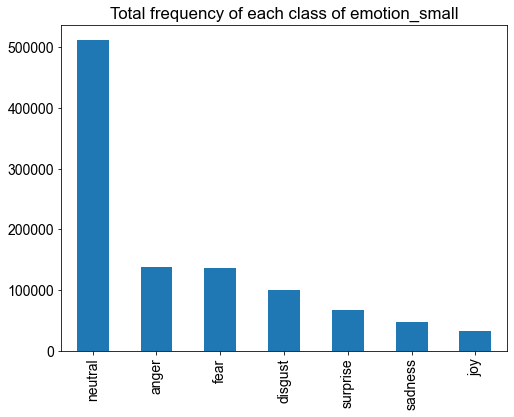

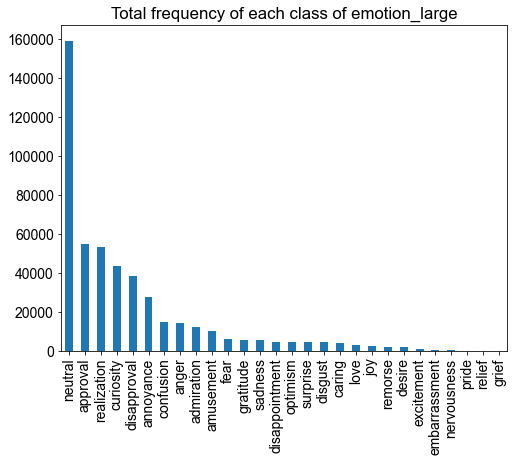

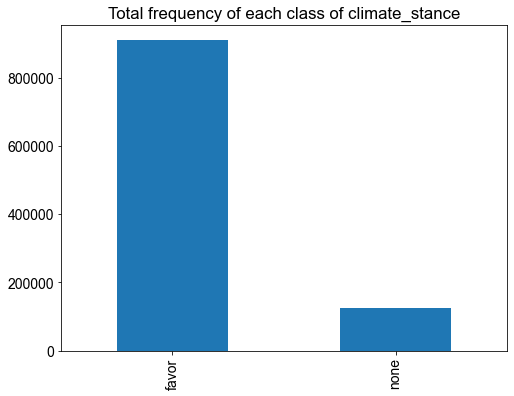

In [43]:
# Plot distribution
for label in ["emotion_small", "emotion_large", "climate_stance"]:
    df.groupby(by=label)[label].count().sort_values(ascending=False).plot.bar()
    plt.title(f"Total frequency of each class of {label}")
    plt.xlabel("")
    plt.show()

## Category distribution over time

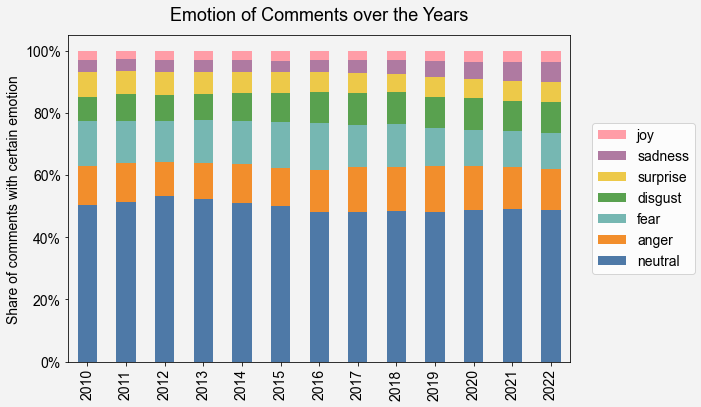

In [118]:
# Plot emotion over the years
custom_colors = ["#4e79a7","#f28e2c","#76b7b2","#59a14f","#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab"]
plt.rcParams["figure.figsize"] = (9,6)

for label in ["emotion_small"]:#, "emotion_large", "climate_stance"]:
    distrib_time_df = df.copy().groupby(by=["created_year", label]).size().unstack(fill_value=0)
    distrib_time_df = distrib_time_df.div(distrib_time_df.sum(axis=1), axis=0) # Make y-axis relative
    distrib_time_df = distrib_time_df.sort_values(by=2022, axis=1, ascending=False)

    fig = plt.figure(facecolor='#F3F3F3')
    ax = plt.axes()
    ax.set_facecolor("#F3F3F3")
    
    distrib_time_df.plot(kind='bar', stacked=True, color=custom_colors, ax=ax)
    
    # Modify labels
    plt.xlabel("")
    plt.ylabel('Share of comments with certain emotion')
    plt.title(f"Emotion of Comments over the Years", size=18, pad=15)
    
    # axis as percentages
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

    # Legend in custom order
    handles, labels = plt.gca().get_legend_handles_labels()
    order = range(len(labels)-1, -1, -1)
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1.03, 0.5))
    
    # Save plot
    # plt.savefig("final_plots/emotions.svg", bbox_inches='tight')

    plt.show()

## Topic distribution per month and year

In [80]:
# Only take the most frequent topics into account, Sorting out 0 since it has too much effect on visuals, sorts our outlier topics too
topic_subset_df = df[(df["topic_number"]> 0) & (df["topic_number"]<= 10)]

topic_subset_df["topic_name"] = [i[2:] for i in topic_subset_df.topic_name]

C:\Users\Felix\AppData\Local\Temp\ipykernel_7460\3273257212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topic_subset_df["topic_name"] = [i[2:] for i in topic_subset_df.topic_name]


In [74]:
topic_subset_df.head(3)

,id,subreddit.name,subreddit.nsfw,created_utc,permalink,sentiment,score,created_date,created_day,created_month,...,created_time,topic_number,topic_name,topic_most_used_words,body_clean_full,climate_stance,emotion_small,emotion_large,sentiment_binary,character_count
19,c0i2twr,wtf,False,1.262412e+09,https://old.reddit.com/r/WTF/comments/akmtn/fi...,-0.5267,2.0,2010-01-02,2,January,...,05:53:51,9,trees_carbon_forests_forest,trees - carbon - forests - forest - tree - woo...,In an atomic sense - if you're looking at carb...,favor,neutral,approval,neutral,935
79,c0i5gtl,politics,False,1.262554e+09,https://old.reddit.com/r/politics/comments/al4...,0.2382,3.0,2010-01-03,3,January,...,21:32:26,2,gore_al_people_global,gore - al - people - global - warming - scienc...,Funny how the wingnuts on the right are silent...,favor,neutral,amusement,neutral,123
131,c0i7qbc,environment,False,1.262650e+09,https://old.reddit.com/r/environment/comments/...,-0.3612,-7.0,2010-01-05,5,January,...,00:07:36,5,denier_deniers_term_silliness,denier - deniers - term - silliness - deny - s...,"Using ""denier"" implies that man made climate c...",favor,neutral,neutral,neutral,84


In [75]:
# Check for Na values
topic_subset_df.isna().sum().sum()

0

c:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:808: UserWarning: The label '_fires_forest_wildfires_bushfires' of <BarContainer object of 12 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


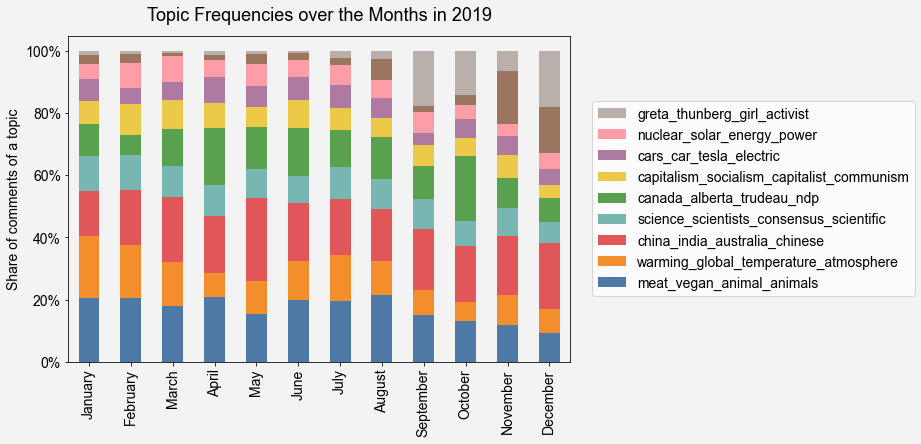

In [119]:
# Create only plot for 2019 for poster

custom_colors = ["#4e79a7","#f28e2c","#e15759","#76b7b2","#59a14f","#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab"]

for year in range (2019, 2020):

    # filter the DataFrame to include only the specified year
    df_temp = topic_subset_df[topic_subset_df['created_year'] == year]

    # aggregate the data by date and topic number
    counts = df_temp.groupby(['created_month', 'topic_name']).size().unstack(fill_value=0)
    counts = counts.div(counts.sum(axis=1), axis=0) # Make y-axis relative
    counts = counts.sort_values(by=1, axis=1, ascending=False)

    counts.index = [calendar.month_name[i] for i in counts.index]

    # change background color
    fig = plt.figure(facecolor='#F3F3F3')
    ax = plt.axes()
    ax.set_facecolor("#F3F3F3")

    # plot the stacked bar chart
    counts.plot(kind='bar', stacked=True, color=custom_colors, ax=ax)

    # axis as percentages
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.ylabel('Share of comments of a topic')
    plt.title(f'Topic Frequencies over the Months in {year}', size=18, pad=15)

    # legend in custom order
    handles, labels = plt.gca().get_legend_handles_labels()
    order = range(len(labels)-1, -1, -1)
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1.03, 0.5))
    
    # Save plot as vector graphic
    # plt.savefig("final_plots/topics.svg", bbox_inches='tight')

    plt.show()

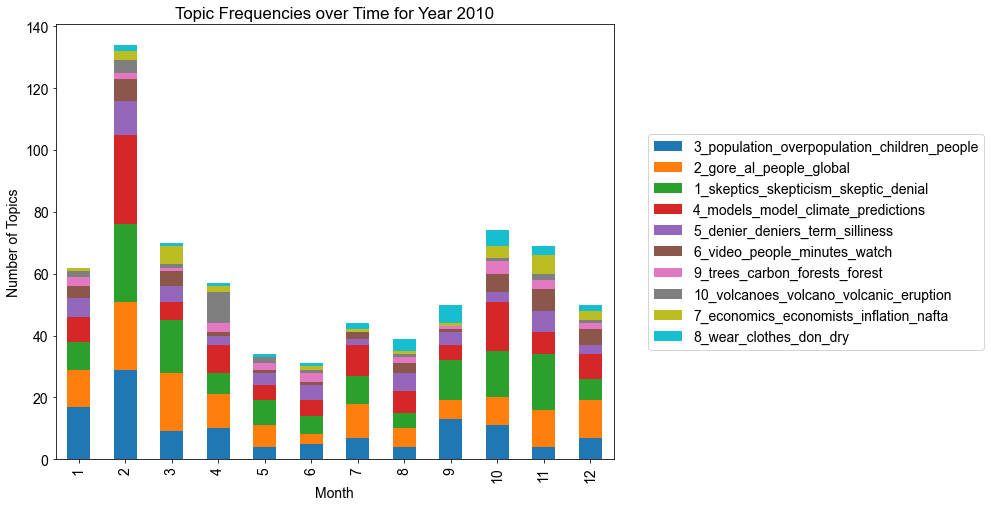

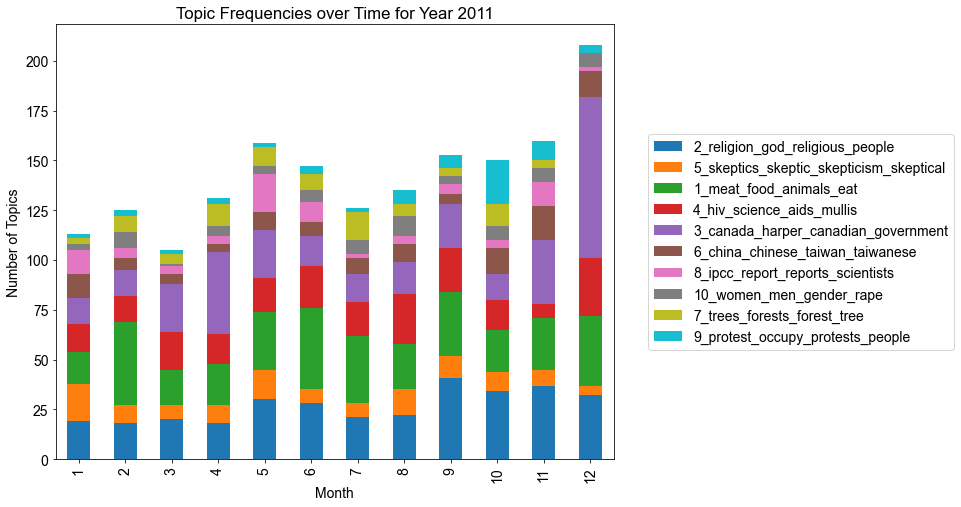

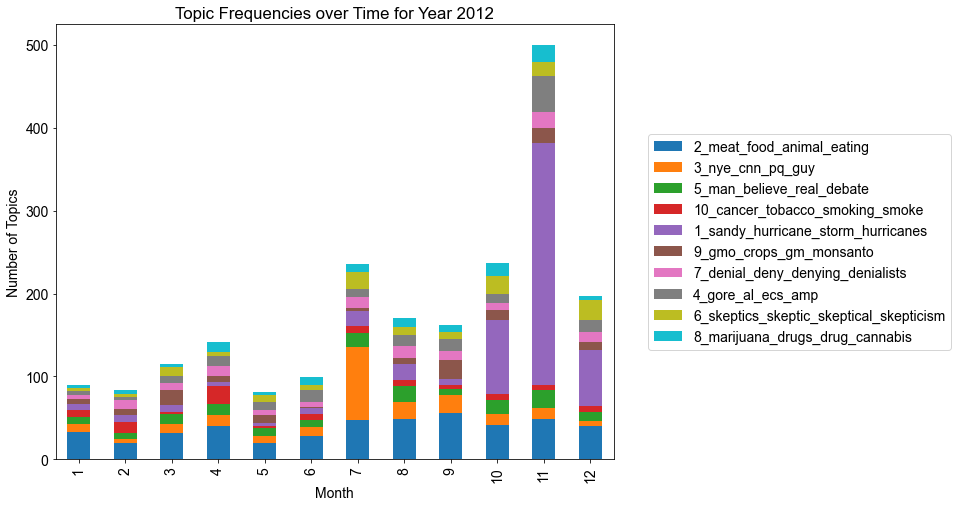

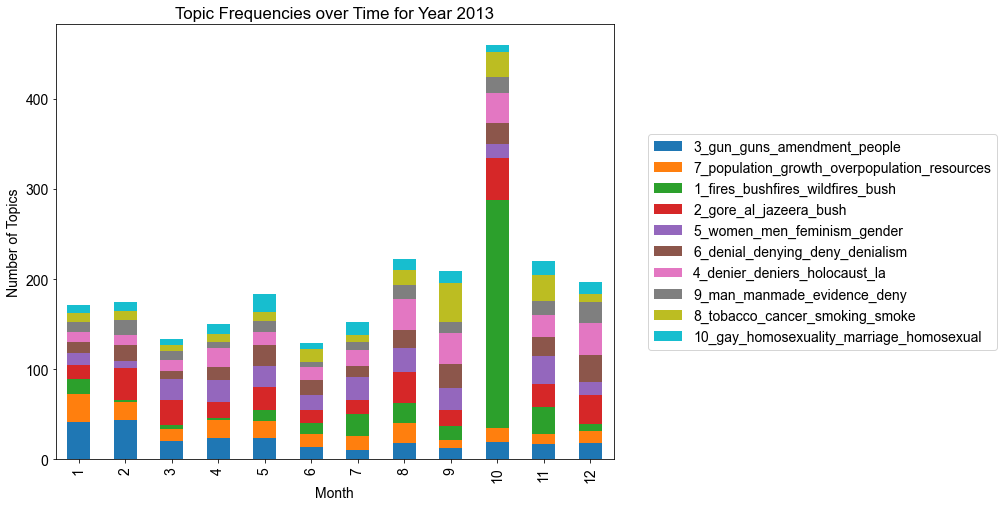

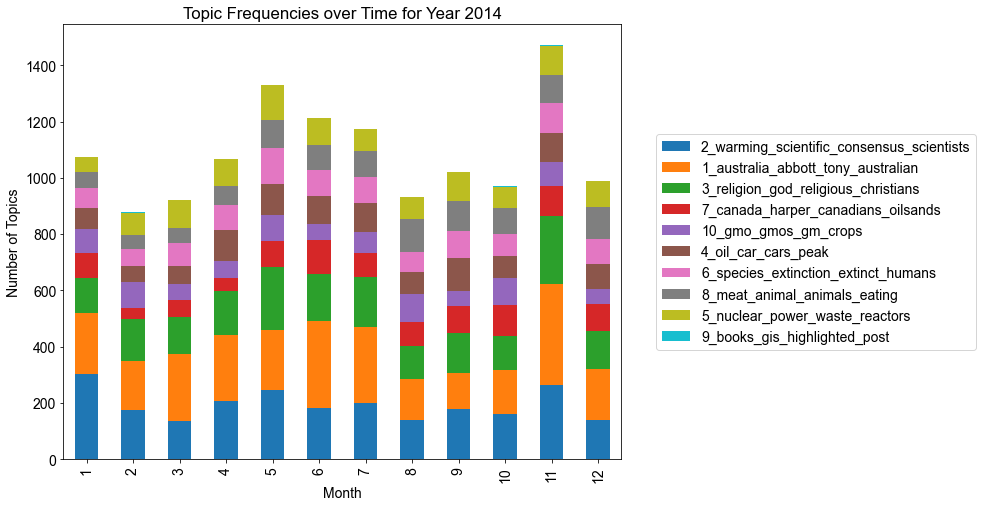

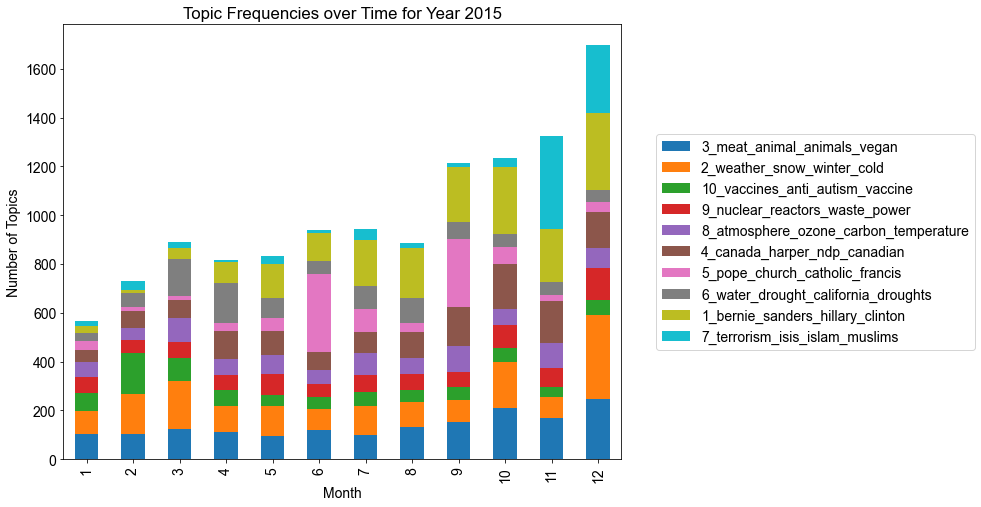

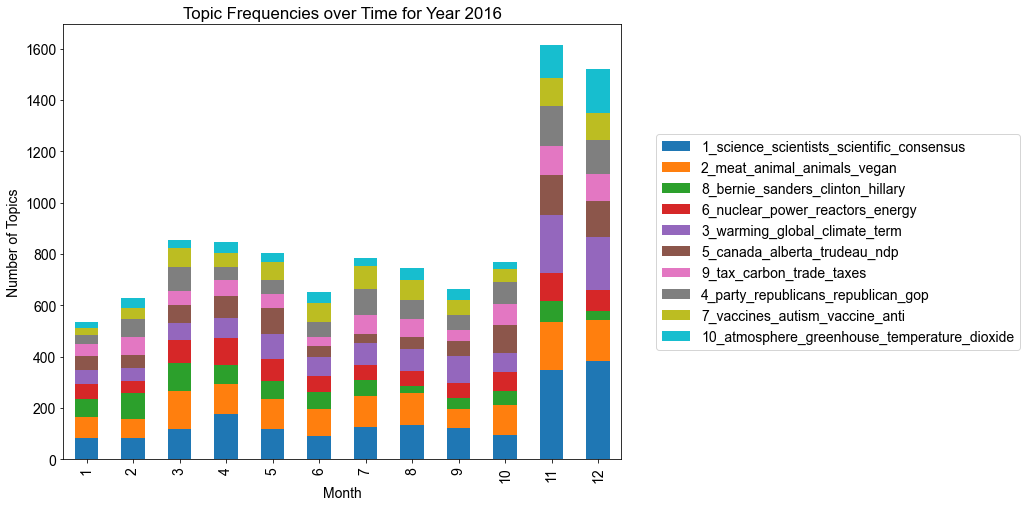

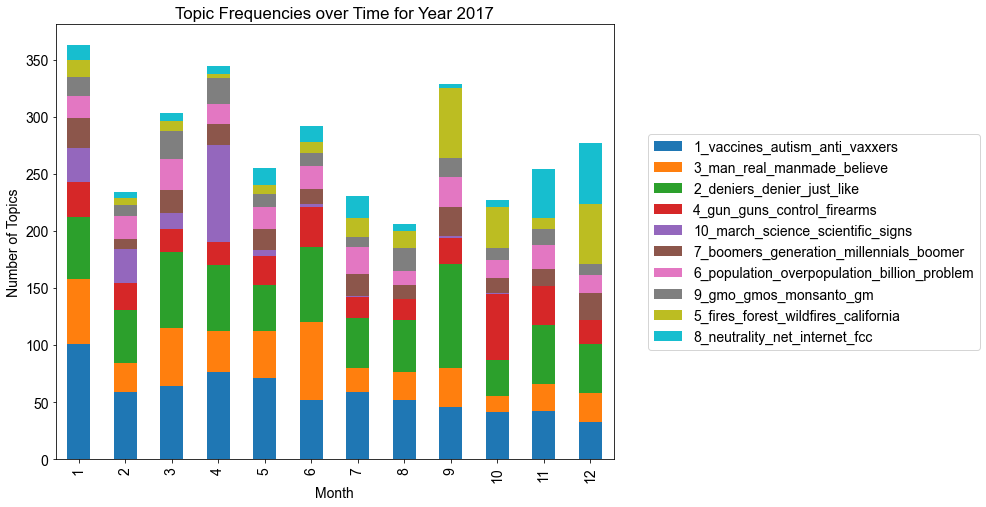

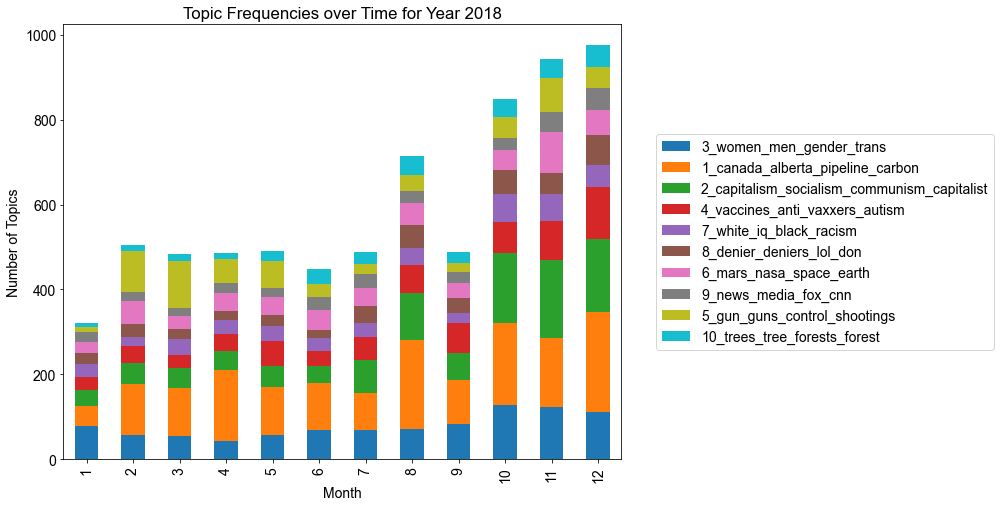

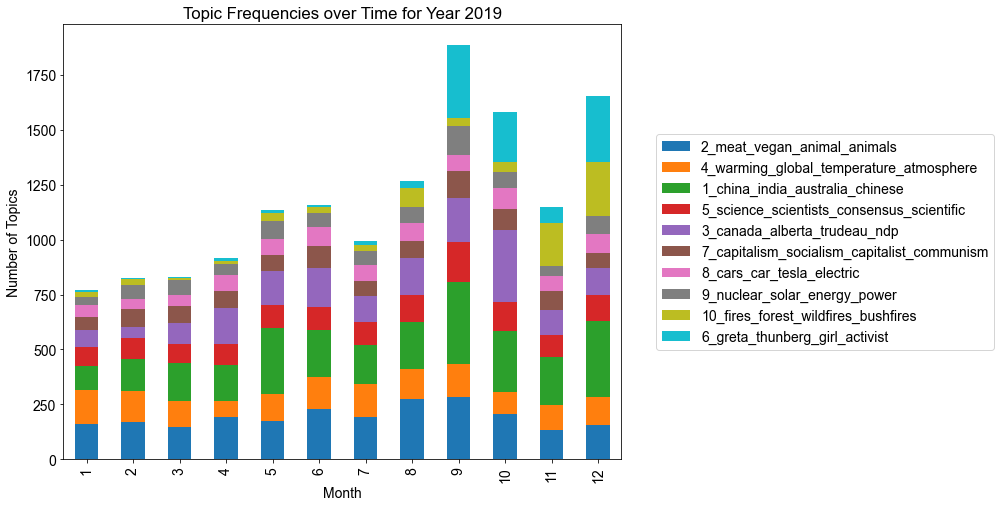

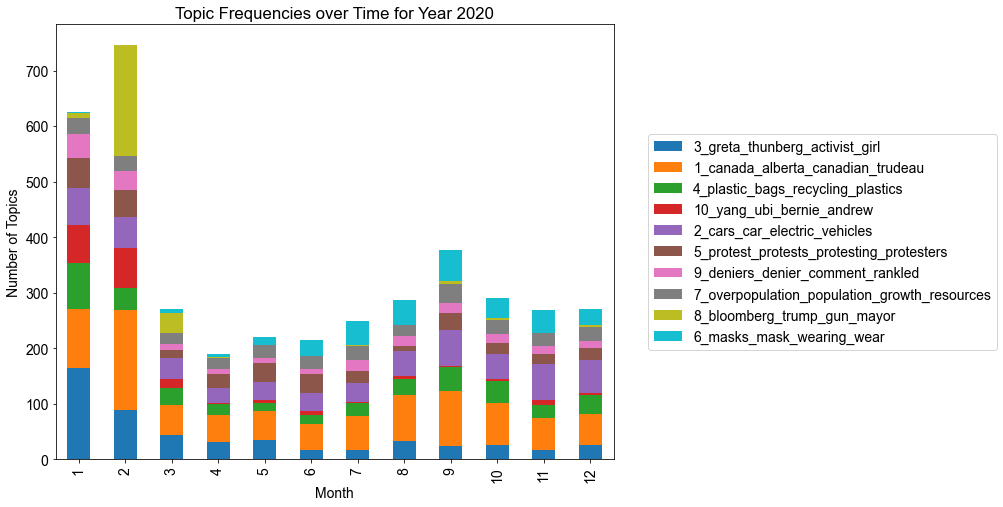

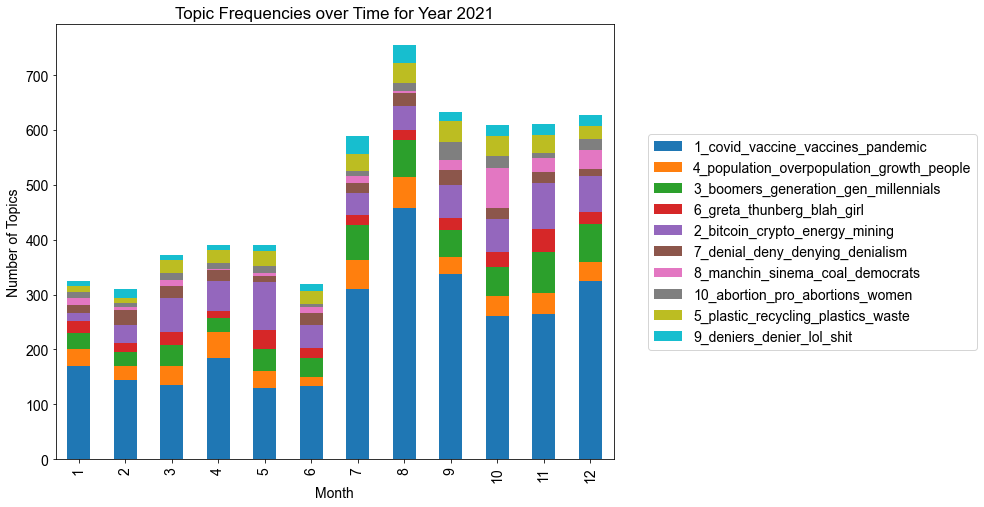

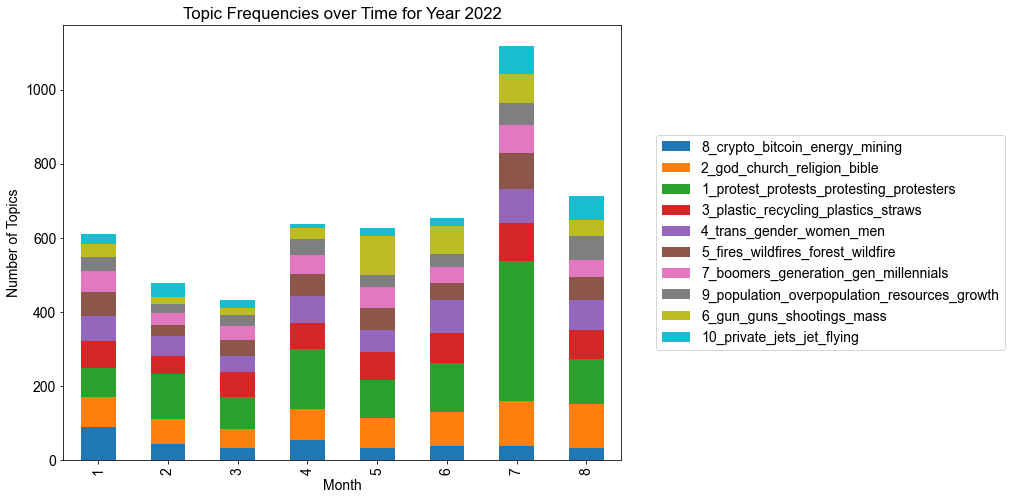

In [14]:
# Create plot for every year
for year in range (2010, 2023):

    # filter the DataFrame to include only the specified year
    df_temp = topic_subset_df[topic_subset_df['created_year'] == year]

    # aggregate the data by date and topic number
    counts = df_temp.groupby(['created_month', 'topic_name']).size().unstack(fill_value=0)
    counts = counts.div(counts.sum(axis=1), axis=0) # Make y-axis relative
    counts = counts.sort_values(by=1, axis=1, ascending=False)

    # plot the stacked bar chart
    counts.plot(kind='bar', stacked=True)
    plt.xlabel('Month')
    plt.ylabel('Number of Topics')
    plt.title(f'Topic Frequencies over Time for Year {year}')
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    plt.show()